# Sanyam Gupta
# 50359154

In [15]:
!pip install validclust

## K-Means

Step 1 - Importing libraries

In [16]:
import tensorflow
import cv2
import numpy as np
from sklearn.metrics import silhouette_score, pairwise_distances
import validclust
from matplotlib import pyplot
from keras.models import Model, Sequential

from keras.layers import Dense, Input, Conv2D, UpSampling2D, BatchNormalization, MaxPooling2D, Conv2DTranspose
# import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import keras

Step 2 - loading Data

In [17]:
train, test = tensorflow.keras.datasets.cifar10.load_data()
greyscale = lambda data : np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in data])
reshape = lambda data : data.reshape(data.shape[0], data.shape[1]*data.shape[1])

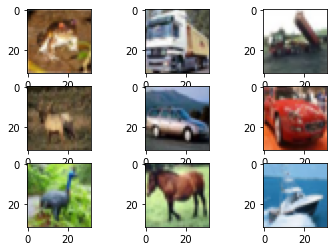

In [18]:
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(train[0][i])
pyplot.show()

Step 3 - Greyscaling and reshaping ndarray

In [19]:
x_train_org, y_train_org = np.array(train[0]), np.array(train[1])
x_test_org, y_test_org = np.array(test[0]), np.array(test[1])
x_train = reshape(greyscale(x_train_org))
x_test = reshape(greyscale(x_test_org))


Step 4 - Helper funtions

In [20]:
def train_model(input_data):

    for i in range(maximum_iterations):
        classes = {}
        for i in range(10):
            classes[i] = []

        for data in input_data:
            dist = [np.linalg.norm(data-centroids[centroid]) for centroid in centroids]
            min_dist = min(dist)
            min_dist_index = dist.index(min_dist)
            classes[min_dist_index].append(data)

        prev = dict(centroids)
        for element in classes:
            centroids[element] = np.average(classes[element],axis=0)

        optimized = True
        for element in centroids:
            original = prev[element]
            curr = centroids[element]
            if np.sum((curr-original)/original*100.0) > tolerance:
                optimized = False
                
        if optimized:
            print(f"optimized in {i} iterations")
            break

def predict(predict_on):
    dist = [np.linalg.norm(predict_on-centroids[element]) for element in centroids]
    cluster = dist.index(min(dist))
    return cluster

Step 5 - Training Model and predicting

In [21]:
maximum_iterations = 50

centroids = {index: x_train[index] for index in range(10)}
tolerance = 0.001
train_model(x_train)

predicted = np.zeros(y_test_org.shape)
for index in range(len(x_test)):
    predicted[index] = predict(x_test[index])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide


Step 6 - Ascertain performance

In [22]:
silhouette= silhouette_score(x_test,predicted)
dist = pairwise_distances(x_test)
dunn = validclust.indices.dunn(dist, predicted.T[0])

print(f'ASC: {silhouette}')
print(f'DI: {dunn}')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ASC: 0.05587534665611295
DI: 0.09360165857070273


# AutoEncoder

Step 1 - Define Model

In [23]:
x_train = greyscale(x_train_org)
x_test = greyscale(x_test_org)
n_epocs = 20
b_size=100

original = Input(shape=(32, 32, 1))
encode_l1 = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(original)
encode_l2 = MaxPooling2D((2, 2), strides=2, padding='same')(encode_l1)
encode_l3 = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(encode_l2)
encoded = MaxPooling2D((2, 2), strides=2, padding='same')(encode_l3)

decode_l1 = Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(encoded)
decode_l2 = Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(decode_l1)
decoded = Conv2D(1, (3, 3), strides=1, activation='linear', padding='same')(decode_l2)

Step 2 - Fit Data and Generate Images

In [24]:
autoencoder = keras.Model(original, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(x_train, x_train, epochs=n_epocs, batch_size=b_size)
pred_imgs = autoencoder.predict(x_train)

Epoch 1/20
500/500 [==============================] - 9s 16ms/step - loss: 944.9310
Epoch 2/20
500/500 [==============================] - 8s 16ms/step - loss: 221.7312
Epoch 3/20
500/500 [==============================] - 8s 16ms/step - loss: 179.9613
Epoch 4/20
500/500 [==============================] - 8s 16ms/step - loss: 160.1785
Epoch 5/20
500/500 [==============================] - 8s 16ms/step - loss: 145.4683
Epoch 6/20
500/500 [==============================] - 8s 16ms/step - loss: 135.7275
Epoch 7/20
500/500 [==============================] - 8s 16ms/step - loss: 128.5647
Epoch 8/20
500/500 [==============================] - 8s 16ms/step - loss: 122.5231
Epoch 9/20
500/500 [==============================] - 8s 16ms/step - loss: 117.9803
Epoch 10/20
500/500 [==============================] - 8s 16ms/step - loss: 113.8278
Epoch 11/20
500/500 [==============================] - 8s 16ms/step - loss: 110.9886
Epoch 12/20
500/500 [==============================] - 8s 16ms/step - loss

Step 3 - Ascertaining performance

In [14]:
encoder = Model(inputs=original, outputs=encoded)
encoded_input = encoder.predict(x_test).reshape(-1,2048)
x_silhouette = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[1])

clustering_model = KMeans(n_clusters=10, init='random', max_iter=300, random_state=0)
classes = clustering_model.fit_predict(encoded_input)
silhouette = silhouette_score(x_silhouette,classes)
print(f'ASC: {silhouette}')

ASC: 0.04388410828980502


Original Images


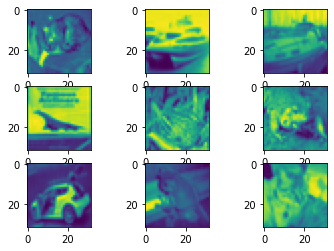

In [34]:
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(x_test[i].reshape(32, 32))
pyplot.show()

Encoded images


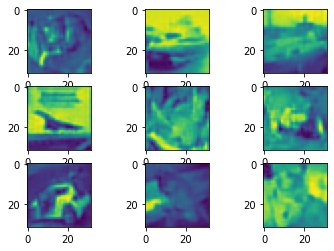

In [33]:
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(pred_imgs[i].reshape(32,32))
pyplot.show()